**Udemy 6-11. A More Challenging Sequence - Part3**

# Part 3 - LSTM Model

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

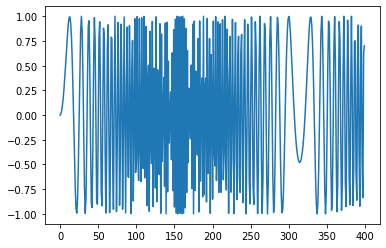

In [12]:
# make the original data
N = 400
series = np.sin(0.01*np.arange(N)**2)

# plot it
plt.plot(series)
plt.show()

In [13]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, ", Y.shape", Y.shape)

X.shape (390, 10, 1) , Y.shape (390, 1)


In [14]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [15]:
# Define Simple RNN
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super().__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.lstm = nn.LSTM(
                input_size = self.D,
                hidden_size = self.M, 
                num_layers = self.L,
                batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        
        # get LSTM unit output
        # out is size (N, T, M)
        # 2nd return value is hidden states at each hidden layer (N, L, M)
        # we don't need those now
        out, _ = self.lstm(X, (h0, c0))
        
        # we only want h(T) at the final time step
        # in_featue: N x M | out_feature: N x K
        out = self.fc(out[:,-1,:])
        return out

In [16]:
# instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [18]:
# Make inputs and outputs target
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

# Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [19]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 50 == 0:
            print(f"Epoch {it+1}/{epochs}, Train_loss: {train_losses[it]:.4f}, Test_loss: {test_losses[it]:.4f}")
    
    return train_losses, test_losses

In [20]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200)

Epoch 50/200, Train_loss: 0.1268, Test_loss: 0.2167
Epoch 100/200, Train_loss: 0.0261, Test_loss: 0.1650
Epoch 150/200, Train_loss: 0.0162, Test_loss: 0.0961
Epoch 200/200, Train_loss: 0.0087, Test_loss: 0.0866


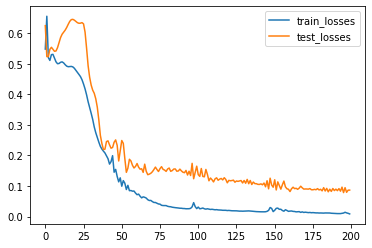

In [21]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()
plt.show()

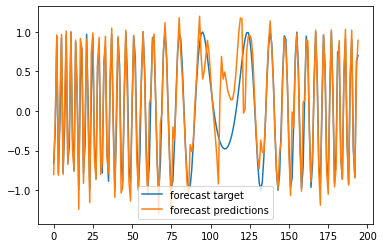

In [22]:
# "Wrong" forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item()
    i += 1
    
    # update the prediction list
    validation_predictions.append(p)

plt.figure()  
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()

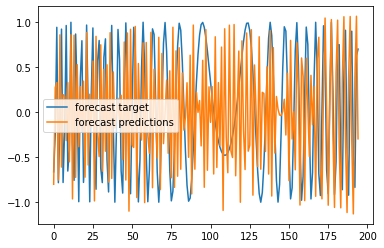

In [23]:
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    # update the prediction lsit
    validation_predictions.append(p[0,0].item())
    
    # make the new input (from the model forcasts)
    last_x = torch.cat((last_x[1:], p[0]))

plt.figure() 
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()